### Fáza 1. Prieskumná analýza

### A. Analýza štruktúr dát

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, HTML
from scipy.stats import pearsonr,spearmanr

SEED = 42
np.random.seed(SEED)

DATA_DIR = "./115"

# Načítanie dát

df_obs = pd.read_csv(os.path.join(DATA_DIR, "observation.csv"), sep='\t', encoding='utf-8-sig')
df_pat = pd.read_csv(os.path.join(DATA_DIR, "patient.csv"), sep='\t', encoding='utf-8-sig')
df_sta = pd.read_csv(os.path.join(DATA_DIR, "station.csv"), sep='\t', encoding='utf-8-sig')


In [31]:
# --- A. Analýza štruktúr dát ---

# Funkcia na rýchly prehľad datasetu

def dataset_summary(df, name):
    print("Dataset:",name)
    print("Počet riadkov: ",df.shape[0])
    print("Počet stĺpcov: ",df.shape[1])
    display(df.head())
    display(df.info())


dataset_summary(df_obs, "observation.csv")
dataset_summary(df_pat, "patient.csv")
dataset_summary(df_sta, "station.csv")



Dataset: observation.csv
Počet riadkov:  12169
Počet stĺpcov:  23


,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,CO,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude
0,96.634591,80.009013,8.685891,17.518665,41.509058,45.163316,144.295418,104.803180,34.978370,10.828257,...,4.088809,40.790753,53.666253,62.281085,54.919133,0.300000,38.410597,1.0,25.67927,-80.31727
1,96.640621,74.589540,13.724679,15.588010,40.198284,50.791918,110.819791,103.974975,35.193140,9.818858,...,4.036563,43.207084,58.219436,45.805412,58.818949,0.213967,39.018173,0.0,-23.79750,-48.59278
2,98.146757,85.019981,7.766128,18.747887,41.964458,63.858679,91.591179,106.573202,35.938901,9.767053,...,4.224814,48.594592,56.163501,45.538311,46.333772,0.205624,30.761858,1.0,-5.41667,38.01667
3,98.391300,73.823193,11.114940,15.905309,42.781757,55.433424,59.373133,103.438804,34.843787,12.695630,...,4.030798,51.561544,42.193516,44.665135,27.899934,0.292025,28.550364,1.0,34.56861,105.89333
4,97.391221,78.702018,12.126423,14.923299,38.946213,52.511153,100.147921,102.652685,36.109030,10.813473,...,4.070682,51.560475,45.447019,63.837901,50.321388,0.242503,38.698971,1.0,51.65333,5.28750


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12169 entries, 0 to 12168
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SpO₂                   12169 non-null  float64
 1   HR                     12169 non-null  float64
 2   PI                     12169 non-null  float64
 3   RR                     12169 non-null  float64
 4   EtCO₂                  12169 non-null  float64
 5   FiO₂                   12169 non-null  float64
 6   PRV                    12169 non-null  float64
 7   BP                     12169 non-null  float64
 8   Skin Temperature       12169 non-null  float64
 9   Motion/Activity index  12169 non-null  float64
 10  PVI                    12169 non-null  float64
 11  Hb level               12169 non-null  float64
 12  SV                     12169 non-null  float64
 13  CO                     12169 non-null  float64
 14  Blood Flow Index       12169 non-null  float64
 15  PP

None

Dataset: patient.csv
Počet riadkov:  2189
Počet stĺpcov:  13


,residence,name,username,blood_group,ssn,mail,registration,job,user_id,address,company,birthdate,station_ID
0,NaN,Pedro Miguel Guerra,ana-luizabrito,O-,36809245189,maria-sophia91@bol.com.br,2022/04/01,Endocrinologista,1293,Viela de Azevedo\r\nNossa Senhora De Fátima\r\...,Santos da Cruz - EI,NaN,403
1,NaN,Brandi Johnson,shawnbrown,AB-,051-02-4229,vdavis@yahoo.com,2022-09-28,NaN,141,"40117 Santana Turnpike\r\nSamuelborough, MT 28818","Tyler, Woodward and Johnson",1937-01-22,345
2,NaN,Brian Arellano,dchandler,O+,498-48-9114,daniellewhite@gmail.com,2025-02-17,"Civil engineer, consulting",1079,"3445 Phillip Place\r\nSouth Daniel, OR 84598",Lopez LLC,NaN,225
3,NaN,渡辺 裕樹,mikiyamaguchi,B+,406-48-8413,vfukuda@hotmail.com,2019-05-04,NaN,1037,山梨県墨田区虎ノ門虎ノ門ヒルズ森タワー14丁目17番9号 外国府間パーク522,吉田通信株式会社,1933-06-16,668
4,NaN,Sig. Jacopo Rossellini,biancaferragni,AB-,CSCLVI77H25E037I,paolomoneta@libero.it,2023/02/06,Herbalist,1141,"Contrada Adelmo, 55\r\n80010, Scalzapecora (NA)",Amaldi-Gussoni Group,NaN,696


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   residence     0 non-null      float64
 1   name          2189 non-null   object 
 2   username      2189 non-null   object 
 3   blood_group   2189 non-null   object 
 4   ssn           2189 non-null   object 
 5   mail          2189 non-null   object 
 6   registration  2189 non-null   object 
 7   job           657 non-null    object 
 8   user_id       2189 non-null   int64  
 9   address       1861 non-null   object 
 10  company       2189 non-null   object 
 11  birthdate     1204 non-null   object 
 12  station_ID    2189 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 222.4+ KB


None

Dataset: station.csv
Počet riadkov:  711
Počet stĺpcov:  6


,QoS,station,latitude,revision,longitude,location
0,maintenance,Baki,9.89206,2024-10-22,43.38531,Africa/Mogadishu
1,good,Voznesensk,47.56494,"11/20/2023, 00:00:00",31.33078,Europe/Kyiv
2,good,Msaken,35.72917,21 Apr 2017,10.58082,Africa/Tunis
3,acceptable,Pottstown,40.24537,13 Nov 2019,-75.64963,America/New_York
4,acceptable,Gilbert,33.35283,2023-09-04,-111.78903,America/Phoenix


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   QoS        711 non-null    object 
 1   station    711 non-null    object 
 2   latitude   711 non-null    float64
 3   revision   711 non-null    object 
 4   longitude  711 non-null    float64
 5   location   711 non-null    object 
dtypes: float64(2), object(4)
memory usage: 33.5+ KB


None

##### 1.1(A) Analýza štruktúr dát
Projekt obsahuje 3 základné súbory:

- **observation.csv** – obsahuje senzorové merania pacienta (napr. SpO₂, HR, RR, tlak, teplotu kože,a iné)
- **patient.csv** – uchováva informácie o pacientoch ako základné(meno, priezvisko,mail,...) tak aj pokročilé(krvná skupina,dátum narodenia,...)
  

- **station.csv** – obsahuje informácie o staniciach, kde boli merania vykonávané (napr.location, stationm, QoS).


Z hľadiska dátových typov sú všetky súbory v poriadku – numerické premenné majú typ `float64`
a textové typ `object`. Dátumové a časové údaje možno budú vyžadovať
konverziu na typ `datetime64` 




## B. Analýza jednotlivých atribútov

Atribút: SpO₂ 



count    12169.000000
mean        97.443128
std          0.851298
min         95.000000
25%         96.724993
50%         97.337068
75%         98.163729
max        100.000000
Name: SpO₂, dtype: float64

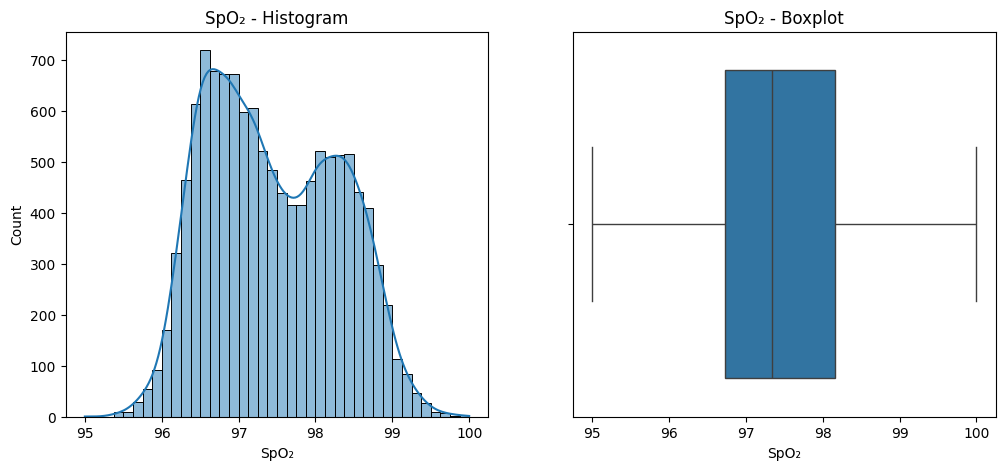

Atribút: HR 



count    12169.000000
mean        80.695691
std          5.169063
min         60.000000
25%         77.260046
50%         80.706068
75%         84.174186
max        100.000000
Name: HR, dtype: float64

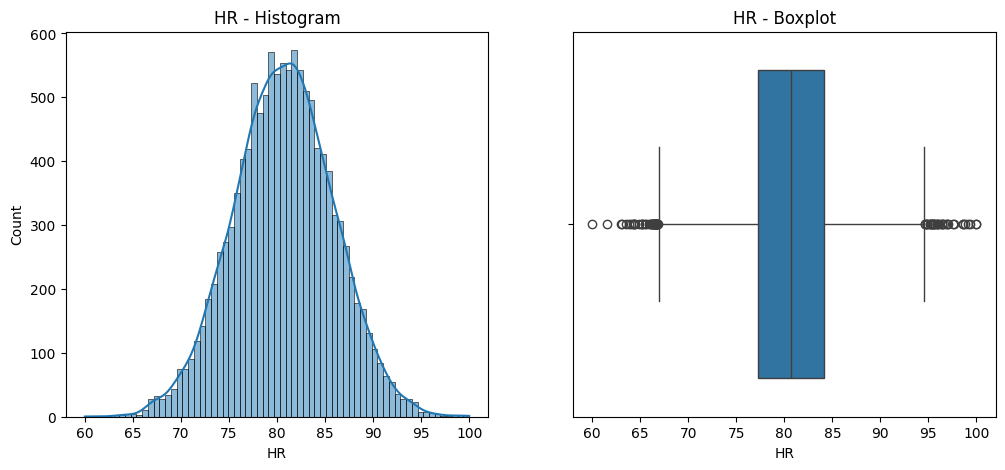

Atribút: PI 



count    12169.000000
mean         9.973503
std          2.531456
min          0.200000
25%          8.263877
50%          9.971865
75%         11.665859
max         20.000000
Name: PI, dtype: float64

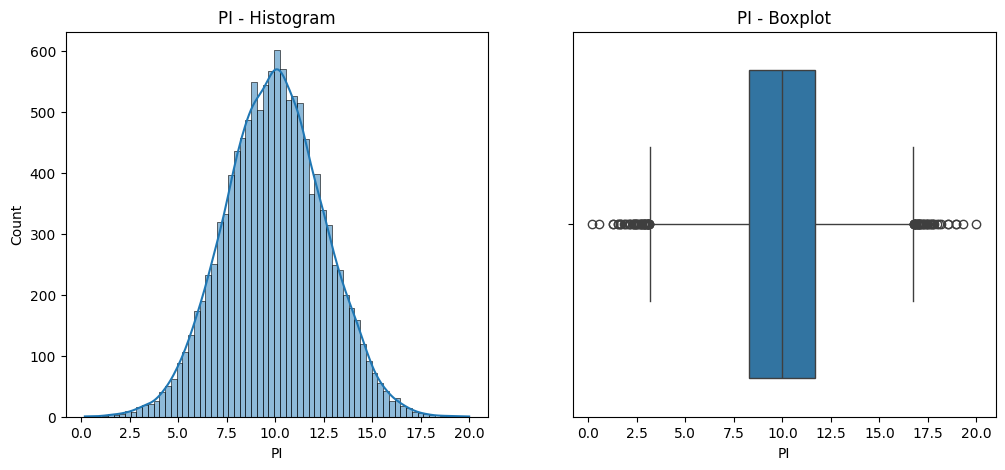

Atribút: RR 



count    12169.000000
mean        16.139896
std          1.221072
min         12.000000
25%         15.271247
50%         16.170931
75%         17.032592
max         20.000000
Name: RR, dtype: float64

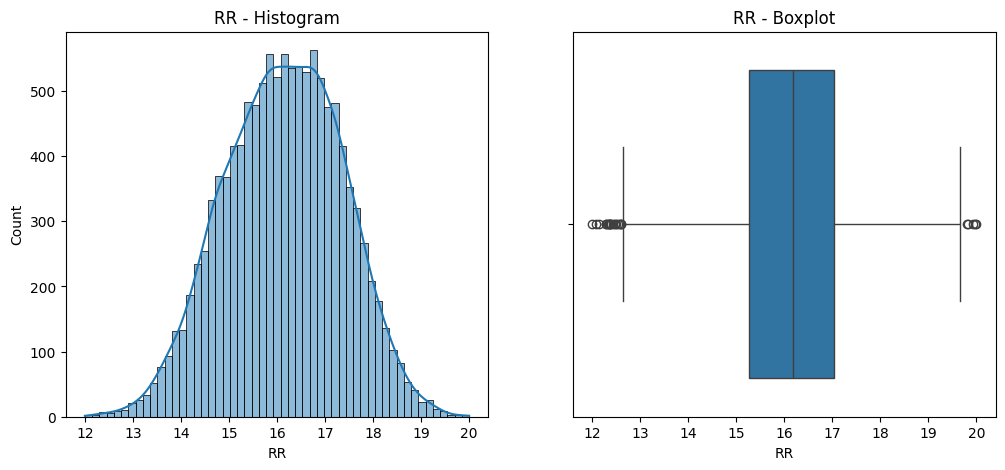

Atribút: EtCO₂ 



count    12169.000000
mean        40.547710
std          1.728305
min         35.000000
25%         39.256018
50%         40.623092
75%         41.954525
max         45.000000
Name: EtCO₂, dtype: float64

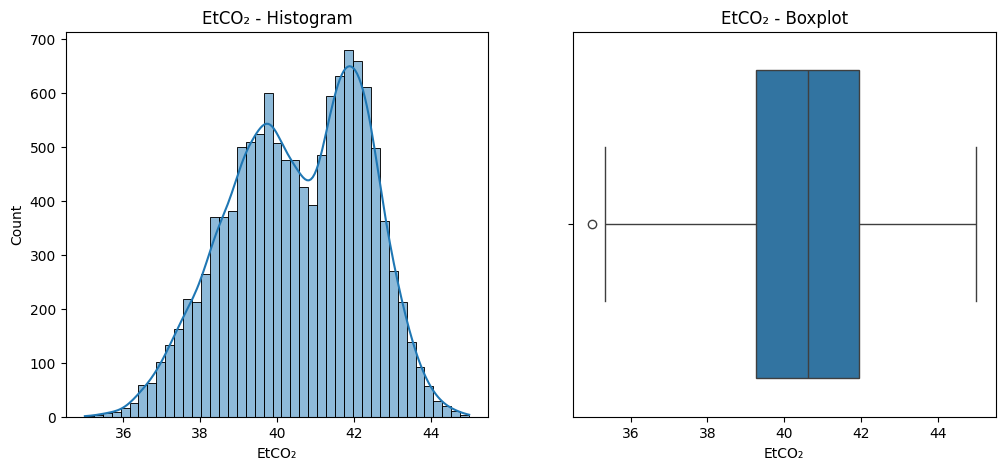

Atribút: FiO₂ 



count    12169.000000
mean        56.802192
std          9.464018
min         21.000000
25%         50.422783
50%         56.775781
75%         63.156327
max        100.000000
Name: FiO₂, dtype: float64

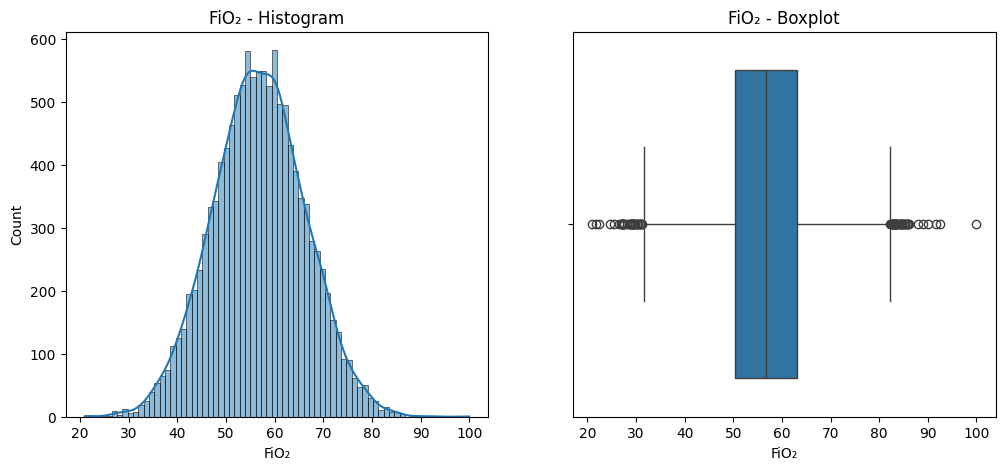

Atribút: BP 



count    12169.000000
mean       104.438311
std          4.087029
min         90.000000
25%        101.688314
50%        104.383293
75%        107.206715
max        120.000000
Name: BP, dtype: float64

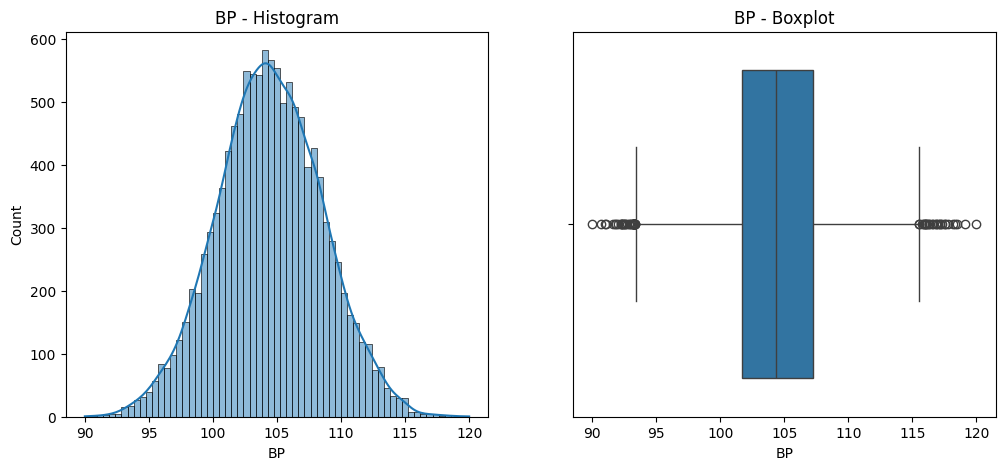

Atribút: Skin Temperature 



count    12169.000000
mean        35.711485
std          0.606075
min         33.000000
25%         35.307101
50%         35.710279
75%         36.112258
max         38.000000
Name: Skin Temperature, dtype: float64

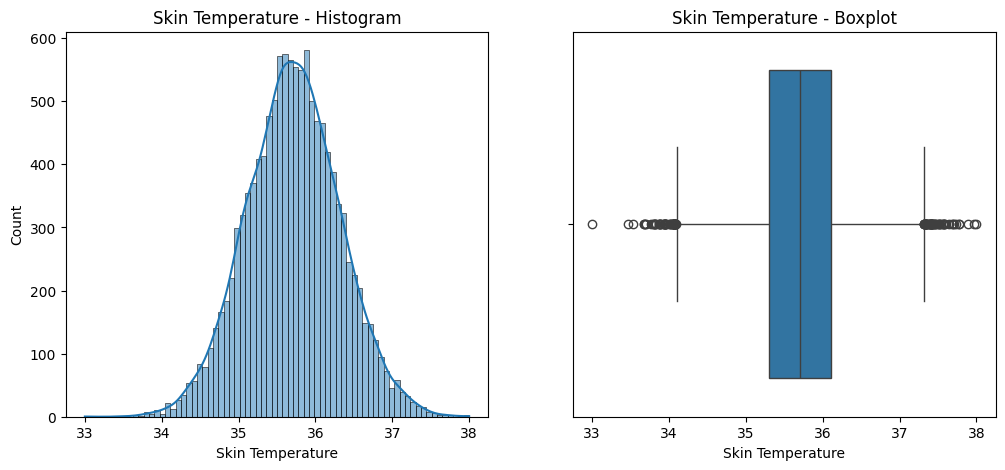

Atribút: Motion/Activity index 



count    12169.000000
mean        10.193994
std          0.999719
min          6.634184
25%          9.523250
50%         10.196181
75%         10.863002
max         13.957933
Name: Motion/Activity index, dtype: float64

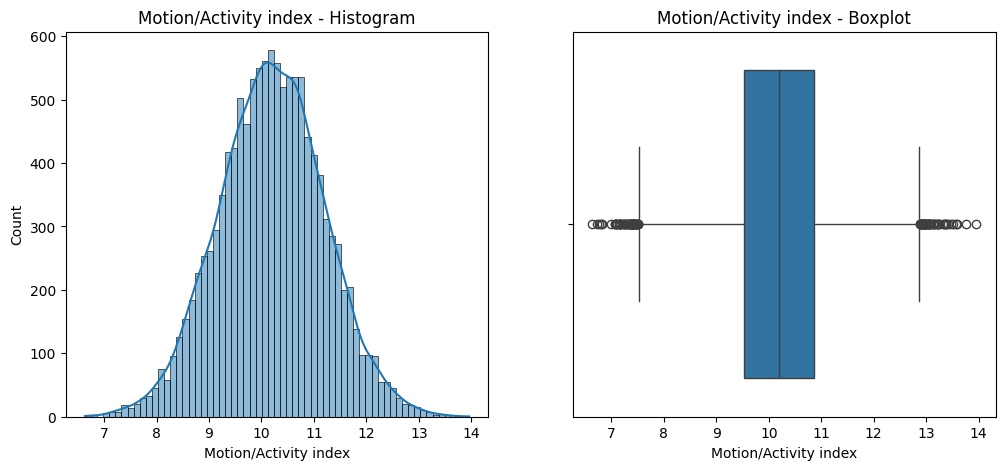

Atribút: CO 



count    12169.000000
mean         4.162138
std          0.204453
min          4.000000
25%          4.053663
50%          4.100742
75%          4.192546
max          8.000000
Name: CO, dtype: float64

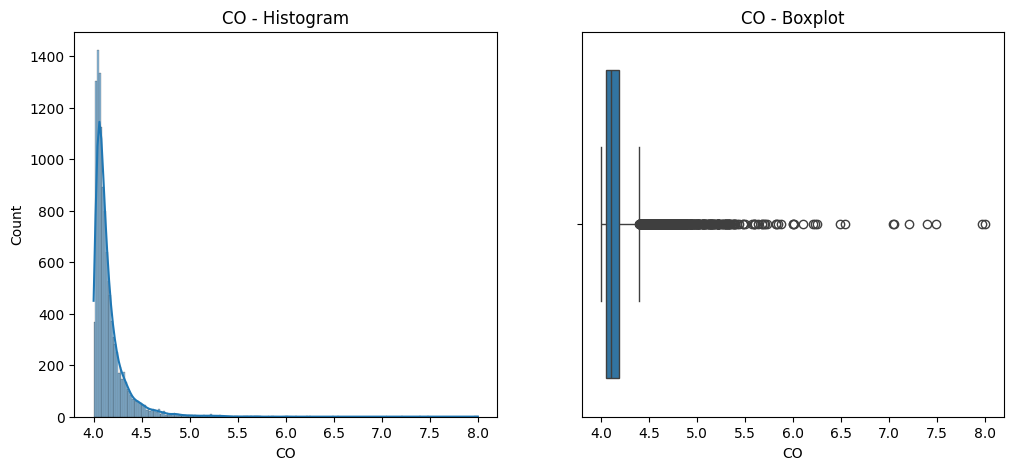

In [13]:
attributes = ['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'BP', 'Skin Temperature', 'Motion/Activity index', 'CO']

for atr in attributes:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    

    print("Atribút:", atr,"\n")
    display(df_obs[atr].describe())
    axes[0].set_title(f"{atr} - Histogram")
    axes[1].set_title(f"{atr} - Boxplot")
    sns.histplot(df_obs[atr].dropna(), kde=True, ax=axes[0])
    sns.boxplot(x=df_obs[atr], ax=axes[1])
    plt.show()


## C Párová analýza dát: Identifikujte vzťahy a závislostí medzi dvojicami atribútov. 


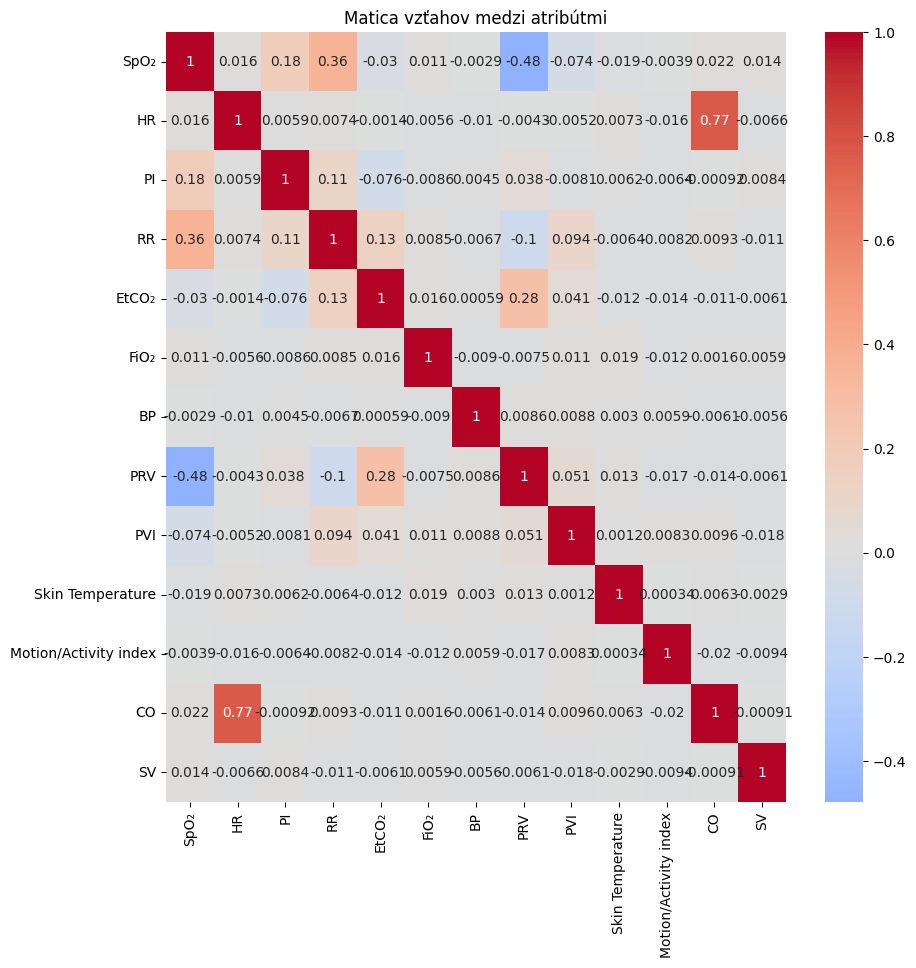

In [29]:
#vsetky numericke atributy
#corr_matrix = df_obs.select_dtypes(include=[np.number]).copy().corr()


#len tie podstatnejšie
corr_matrix = df_obs[['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'BP','PRV','PVI', 'Skin Temperature', 'Motion/Activity index', 'CO','SV',]].corr()


plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matica vzťahov medzi atribútmi')
plt.show()

## D Párová  analýza  dát:  Identifikujte  závislosti  medzi  predikovanou  premennou  a ostatnými premennými (potenciálnymi prediktormi).

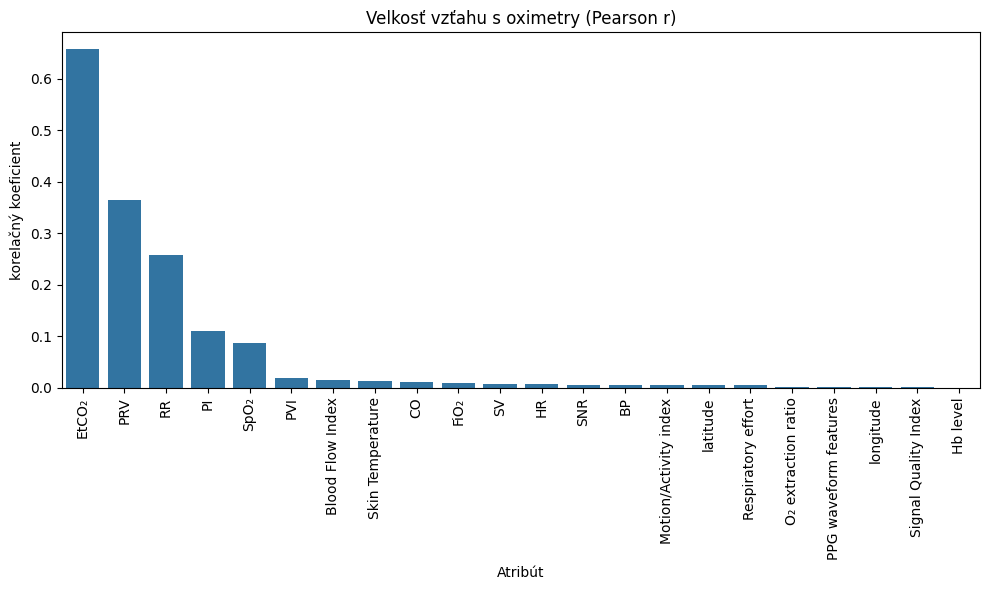

,atribúty,r(Pearson),p-value
0,EtCO₂,0.657310,0.000000e+00
1,PRV,0.364883,0.000000e+00
2,RR,0.256953,9.647412e-183
3,PI,-0.110109,3.864246e-34
4,SpO₂,-0.086103,1.816684e-21
5,PVI,0.018609,4.009079e-02
6,Blood Flow Index,0.014315,1.143288e-01
7,Skin Temperature,-0.013131,1.475096e-01
8,CO,-0.011511,2.041876e-01
9,FiO₂,0.008859,3.284540e-01


In [30]:


#ciselne stplce
num = df_obs.select_dtypes(include=[np.number]).copy()

# korelacia 
corr = num.corr(numeric_only=True)['oximetry'].drop('oximetry')
corr_abs = corr.abs().sort_values(ascending=False)



pv = []
for col in corr_abs.index[:10]: # len top 10
    x = num[col].dropna()
    y = num['oximetry'].loc[x.index]
    r, p = pearsonr(x, y)
    pv.append((col, r, p))
pv_df = pd.DataFrame(pv, columns=['atribúty','r(Pearson)','p-value'])

# 4) Vizualizácia
plt.figure(figsize=(10,6))
sns.barplot(x=corr_abs.index, y=corr_abs.values, order=corr_abs.index)
plt.xticks(rotation=90)
plt.title('Velkosť vzťahu s oximetry (Pearson r)')
plt.xlabel('Atribút')
plt.ylabel('korelačný koeficient')
plt.tight_layout()
plt.show()

pv_df


## E Dokumentácia zistení

- Pri prvotnej analýze datasetov sme sa zamerali na štruktúru datasetov a vzťahmi medzi jednotlivými atribútami

- dataset pozostáva z troch častí **observation**, **patient**, **station** 

**observion** obsahuje jednotlivé hodnoty pozorovania

**patient** obsahuje informácie o pacientoch ako meno, email, krvná skupina, id a rôzne iné informácie

**station** je dataset obsahujúci stanice kde prebiehali merania, ich názov, miesto, ...
